# Process Data - Notebook

### Visualização do Banco de Dados

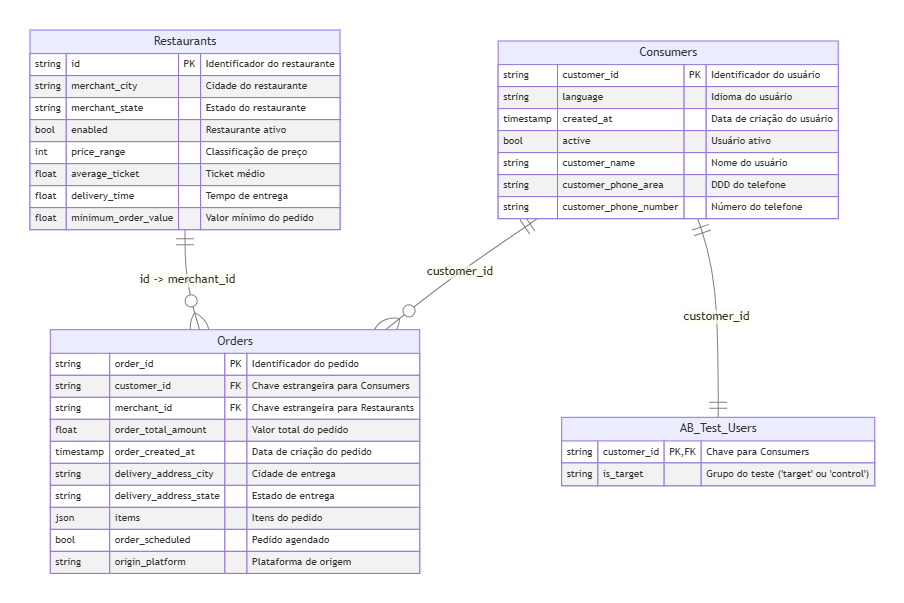

In [1]:
from IPython.display import Image
Image(filename='static/image.png')

### Configurando Ambiente

In [2]:
import os
from pyspark.sql import SparkSession
import findspark
from IPython import get_ipython

from pyspark.sql.functions import col, when, lower, upper, year, month, to_timestamp,  sum as spark_sum

os.environ.pop("SPARK_HOME", None)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

findspark.init()

# Caminho absoluto do notebook (via IPython)
notebook_path = get_ipython().run_line_magic('pwd', '')

# Altera o diretório de trabalho para o notebook atual
os.chdir(notebook_path)

spark = SparkSession.builder \
    .appName("Pyspark") \
    .master("local[*]") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/21 19:56:43 WARN Utils: Your hostname, CVER-CE-628, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/21 19:56:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/21 19:56:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/21 19:56:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Leitura e tratamento dos dados

### 1) Consumers & AB Test

In [3]:
################################
# Leitura do arquivo CSV de consumidores
################################

df_consumers = spark.read.option("header", True) \
                         .option("inferSchema", True) \
                         .option("compression", "gzip") \
                         .csv("data_files/consumer.csv.gz")

# Mostrar as 5 primeiras linhas
df_consumers.show(5)

# 1. Esquema das colunas
df_consumers.printSchema()

# 2. Estatísticas básicas (contagem, média, std, min, max)
df_consumers.describe().show()

# 3. Contagem de valores nulos por coluna
null_counts = df_consumers.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_consumers.columns
])

null_counts.show()

################################
# Transformações e Limpeza de Dados
################################

# 1. Preencher valores nulos em 'customer_name' com 'Desconhecido'
df_consumers = df_consumers.fillna({'customer_name': 'Desconhecido'})

# 2. Remover duplicatas com base em 'customer_id'
df_consumers = df_consumers.dropDuplicates(['customer_id'])

# 3. Converter 'language' para minúsculo
df_consumers = df_consumers.withColumn('language', lower(col('language')))

# 4. Converter 'created_at' para timestamp
df_consumers = df_consumers.withColumn('created_at', to_timestamp('created_at'))

# 5. Garantir que 'customer_phone_area' e 'customer_phone_number' sejam string
df_consumers = df_consumers.withColumn('customer_phone_area', col('customer_phone_area').cast('string'))
df_consumers = df_consumers.withColumn('customer_phone_number', col('customer_phone_number').cast('string'))

# 6. Criar colunas de ano e mês de criação
df_consumers = df_consumers.withColumn('ano_criacao', year(col('created_at')))
df_consumers = df_consumers.withColumn('mes_criacao', month(col('created_at')))

################################
# Leitura do arquivo CSV de A/B Test
################################

# 1. Ler o CSV
df_ab_test = spark.read.option("header", True) \
                       .option("inferSchema", True) \
                       .csv("data_files/ab_test_ref.csv")

print("DataFrame ab_test carregado com sucesso!")
# 2. Mostrar as 5 primeiras linhas
df_ab_test.show(5)

# 3. Esquema das colunas
df_ab_test.printSchema()

print("Estatísticas do DataFrame ab_test:")
# 4. Estatísticas básicas
df_ab_test.describe().show()

print("Contagem de valores nulos por coluna:")
# 5. Contagem de valores nulos por coluna
null_counts = df_ab_test.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_ab_test.columns
])

null_counts.show()

################################
# Transformações e Limpeza de Dados A/B Test
################################

# 1. Mostrar os valores únicos de 'is_target' ANTES do mapeamento
print("Valores únicos em 'is_target' ANTES do mapeamento:")
df_ab_test.select("is_target").distinct().show()

# 2. Mapear 'target' → 1, 'control' → 0; outros → null (usando when)
df_ab_test = df_ab_test.withColumn(
    "is_target",
    when(col("is_target") == "target", 1)
    .when(col("is_target") == "control", 0)
    .otherwise(None)
)

valores_inesperados = df_ab_test.select(
    spark_sum(when(col("is_target").isNull(), 1).otherwise(0)).alias("valores_nulos")
)
print("\nNúmero de linhas com valores inesperados (diferentes de 'target' ou 'control'):")
valores_inesperados.show()

# 4. Remover linhas com customer_id nulo (como no dropna do pandas)
df_ab_test = df_ab_test.filter(col("customer_id").isNotNull())

# 5. Converter 'is_target' para booleano (True/False) em vez de 0/1
df_ab_test = df_ab_test.withColumn("is_target", col("is_target").cast("boolean"))

# --- Verificações finais ---
print("\nValores únicos em 'is_target' APÓS o mapeamento:")
df_ab_test.select("is_target").distinct().show()

print("\nSchema após o tratamento:")
df_ab_test.printSchema()

print("\nPrimeiras linhas do DataFrame limpo e mapeado:")
df_ab_test.show(5, truncate=False)

################################
# Join dos dados de consumidores e A/B Test
################################

# Realiza a junção dos DataFrames pela coluna 'customer_id'
df_consumers_ab_test = df_consumers.join(
    df_ab_test,
    "customer_id",  # Coluna usada para a junção
    "inner"         # Tipo de join: retorna apenas clientes presentes em ambas as tabelas
)

# Para otimizar as próximas operações, é uma boa prática fazer o cache do DataFrame
df_consumers_ab_test.cache()

# Exibe o schema do novo DataFrame e o número total de registros
print("Schema do DataFrame resultante:")
df_consumers_ab_test.printSchema()

total_users_in_test = df_consumers_ab_test.count()
print(f"Número total de clientes no teste A/B: {total_users_in_test}")

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05 11:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14 19:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07 01:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10 20:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-05 21:16:...|  true|       WENDER|                 76|            543232158|
+--------------------+--------+--------------------+------+-------------

25/06/21 19:57:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------+-------------+-------------------+---------------------+
|summary|         customer_id|language|customer_name|customer_phone_area|customer_phone_number|
+-------+--------------------+--------+-------------+-------------------+---------------------+
|  count|              806156|  806156|       806156|             806156|               806156|
|   mean|                NULL|    NULL|          NaN|  49.56521194409022|  5.006510006290433E8|
| stddev|                NULL|    NULL|          NaN|  28.83715985569655|  2.884873531284222E8|
|    min|000009e29b12d8c5b...|   es-ar|       !"VERA|                  0|              1000678|
|    max|ffffeda85b466b481...|   pt-br|      •fanilo|                 99|            999998441|
+-------+--------------------+--------+-------------+-------------------+---------------------+



+-----------+--------+----------+------+-------------+-------------------+---------------------+
|customer_id|language|created_at|active|customer_name|customer_phone_area|customer_phone_number|
+-----------+--------+----------+------+-------------+-------------------+---------------------+
|          0|       0|         0|     0|            0|                  0|                    0|
+-----------+--------+----------+------+-------------+-------------------+---------------------+



DataFrame ab_test carregado com sucesso!
+--------------------+---------+
|         customer_id|is_target|
+--------------------+---------+
|755e1fa18f25caec5...|   target|
|b821aa8372b8e5b82...|  control|
|d425d6ee4c9d4e211...|  control|
|6a7089eea0a5dc294...|   target|
|dad6b7e222bab31c0...|  control|
+--------------------+---------+
only showing top 5 rows
root
 |-- customer_id: string (nullable = true)
 |-- is_target: string (nullable = true)

Estatísticas do DataFrame ab_test:


+-------+--------------------+---------+
|summary|         customer_id|is_target|
+-------+--------------------+---------+
|  count|              806467|   806467|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|000009e29b12d8c5b...|  control|
|    max|                null|   target|
+-------+--------------------+---------+

Contagem de valores nulos por coluna:


+-----------+---------+
|customer_id|is_target|
+-----------+---------+
|          0|        0|
+-----------+---------+

Valores únicos em 'is_target' ANTES do mapeamento:


+---------+
|is_target|
+---------+
|  control|
|   target|
+---------+


Número de linhas com valores inesperados (diferentes de 'target' ou 'control'):
+-------------+
|valores_nulos|
+-------------+
|            0|
+-------------+


Valores únicos em 'is_target' APÓS o mapeamento:


+---------+
|is_target|
+---------+
|     true|
|    false|
+---------+


Schema após o tratamento:
root
 |-- customer_id: string (nullable = true)
 |-- is_target: boolean (nullable = true)


Primeiras linhas do DataFrame limpo e mapeado:
+----------------------------------------------------------------+---------+
|customer_id                                                     |is_target|
+----------------------------------------------------------------+---------+
|755e1fa18f25caec5edffb188b13fd844b2af8cf5adedcf77c028f36cb9382ea|true     |
|b821aa8372b8e5b82cdc283742757df8c45eecdd72adf411716e710525d4edf1|false    |
|d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc007f5297541ec40b63b|false    |
|6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c8b535718bbc651ab02|true     |
|dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f5e3763fa657c23a58d|false    |
+----------------------------------------------------------------+---------+
only showing top 5 rows
Schema do DataFrame resultante:
root
 |-- cu

Número total de clientes no teste A/B: 806156


### 2) Restaurante

In [4]:
################################
# Leitura do arquivo CSV de restaurantes
################################

# Lê o arquivo CSV GZIP
df_restaurant = spark.read.option("header", True) \
                          .option("inferSchema", True) \
                          .option("compression", "gzip") \
                          .csv("data_files/restaurant.csv.gz")

print("DataFrame restaurant carregado com sucesso!")
# Mostra as 5 primeiras linhas
df_restaurant.show(5)

# Esquema
df_restaurant.printSchema()

print("Estatísticas do DataFrame restaurant:")
# Estatísticas descritivas
df_restaurant.describe().show()

print("Contagem de valores nulos por coluna:")
# Contagem de valores nulos por coluna
null_counts = df_restaurant.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_restaurant.columns
])
null_counts.show()

################################
# Transformações e Limpeza de Dados de Restaurantes
################################

df_restaurant = (
    df_restaurant
    .dropDuplicates(["id"])
    .fillna({"minimum_order_value": 0.0})
    .withColumn("ano_criacao", year("created_at"))
    .withColumn("mes_criacao", month("created_at"))
    .withColumn("merchant_city", upper("merchant_city"))
    .withColumn("merchant_state", upper("merchant_state"))
    .withColumn("merchant_zip_code", col("merchant_zip_code").cast("string"))
)

print("\n✅ Schema após o tratamento:")
df_restaurant.printSchema()

print("\n✅ Amostra dos dados tratados:")
df_restaurant.show(5, truncate=False)

print("\n✅ Contagem total de registros:")
print(f"Total: {df_restaurant.count()}")

print("\n✅ Contagem de valores nulos por coluna:")
null_counts = df_restaurant.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_restaurant.columns
])
null_counts.show()

print("\n✅ Valores únicos por coluna categórica:")
for col_name in ['enabled', 'merchant_state', 'merchant_country']:
    df_restaurant.select(col_name).distinct().show()

print("\n✅ Estatísticas numéricas:")
df_restaurant.describe([
    'price_range', 'average_ticket', 'takeout_time',
    'delivery_time', 'minimum_order_value'
]).show()

DataFrame restaurant carregado com sucesso!
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23 10:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20 11:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|

### 3) Orders

In [5]:
df_order = spark.read \
    .option("compression", "gzip") \
    .json("data_files/order.json.gz")

# Filtra linhas onde customer_id NÃO é nulo
df_order = df_order.filter(col("customer_id").isNotNull())

print("DataFrame order carregado com sucesso!")
# Mostra as 5 primeiras linhas
df_order.show(5)

# Esquema
df_order.printSchema()

print("Contagem de valores nulos por coluna:")
# Contagem de valores nulos por coluna
null_counts = df_order.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_order.columns
])
null_counts.show()

DataFrame order carregado com sucesso!
+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------

+---+-----------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+-----+-----------+-----------------+------------------+-----------------+----------------+--------+---------------+--------------------+------------------+---------------+
|cpf|customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|items|merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|order_created_at|order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+---+-----------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+

### Junção de todos os dados

In [6]:
print("Iniciando a junção dos DataFrames...")

# Começamos com a base de pedidos (df_order) e vamos enriquecê-la
df_all_data = df_order \
    .join(
        df_restaurant,
        df_order.merchant_id == df_restaurant.id,
        "inner"
    ) \
    .join(
        df_consumers_ab_test,  # Usamos df_consumers como ponte
        df_order.customer_id == df_consumers_ab_test.customer_id,
        "inner"
    )

print("Junção concluída.")


# --- PASSO 2: Selecionar e Renomear as Colunas Desejadas de forma explícita ---

print("Selecionando e renomeando as colunas finais...")

df_all_data = df_all_data.select(
    # Colunas da tabela de Pedidos (df_order)
    df_order.order_id,
    df_order.order_created_at,
    df_order.delivery_address_city,
    df_order.delivery_address_state,
    df_order.order_scheduled,
    df_order.origin_platform,
    df_order.order_total_amount,
    df_order.merchant_id, # <--- Selecionando explicitamente de df_order
    
    # Coluna da tabela de Clientes (df_consumers)
    df_consumers_ab_test.customer_id, # <--- Selecionando explicitamente de df_consumers
    
    # Colunas da tabela de Restaurantes (df_restaurant)
    df_restaurant.price_range,
    df_restaurant.average_ticket,
    df_restaurant.enabled.alias("restaurant_enabled"),
    
    # Coluna da tabela do Teste A/B (df_ab_test)
    df_consumers_ab_test.is_target,
    df_consumers_ab_test.created_at.alias("customer_created_at")
)


# --- PASSO 3: Verificar o Resultado ---

print("\nSchema final do DataFrame consolidado:")
df_all_data.printSchema()

print("\n5 primeiras linhas do DataFrame final:")
df_all_data.show(5, truncate=False)

# Para otimizar análises futuras, é uma excelente prática colocar o DataFrame em cache
df_all_data.cache()

print(f"\nDataFrame final criado e em cache com {df_all_data.count()} linhas.")

Iniciando a junção dos DataFrames...
Junção concluída.
Selecionando e renomeando as colunas finais...

Schema final do DataFrame consolidado:
root
 |-- order_id: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- origin_platform: string (nullable = true)
 |-- order_total_amount: double (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- price_range: integer (nullable = true)
 |-- average_ticket: double (nullable = true)
 |-- restaurant_enabled: boolean (nullable = true)
 |-- is_target: boolean (nullable = true)
 |-- customer_created_at: timestamp (nullable = true)


5 primeiras linhas do DataFrame final:


+----------------------------------------------------------------+------------------------+---------------------+----------------------+---------------+---------------+------------------+----------------------------------------------------------------+----------------------------------------------------------------+-----------+--------------+------------------+---------+-----------------------+
|order_id                                                        |order_created_at        |delivery_address_city|delivery_address_state|order_scheduled|origin_platform|order_total_amount|merchant_id                                                     |customer_id                                                     |price_range|average_ticket|restaurant_enabled|is_target|customer_created_at    |
+----------------------------------------------------------------+------------------------+---------------------+----------------------+---------------+---------------+------------------+-----------------

25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_46 in memory! (computed 2.4 MiB so far)
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_49 in memory! (computed 1353.7 KiB so far)
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_44 in memory! (computed 2.3 MiB so far)
25/06/21 20:03:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_273_50 in memory.
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_47 in memory! (computed 1348.0 KiB so far)
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_45 in memory! (computed 2.4 MiB so far)
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_42 in memory! (computed 1343.6 KiB so far)
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_50 in memory! (computed 504.0 B so far)
25/06/21 20:03:11 WARN MemoryStore: Not enough space to cache rdd_273_43 in memory! (c


DataFrame final criado e em cache com 3661050 linhas.


### Salvar dados em `parquet`

In [7]:
os.mkdir("processed_data") if not os.path.exists("processed_data") else None

# Salvar o DataFrame final em formato Parquet
df_consumers_ab_test.write.mode("overwrite").parquet("processed_data/df_consumers_ab_test.parquet")
df_restaurant.write.mode("overwrite").parquet("processed_data/df_restaurant.parquet")
df_order.write.mode("overwrite").parquet("processed_data/df_order.parquet")
df_all_data.write.mode("overwrite").parquet("processed_data/df_all_data.parquet")


25/06/21 12:51:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/06/21 12:51:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/06/21 12:51:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/06/21 12:51:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/06/21 12:51:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
25/06/21 12:51:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/06/21 12:51:43 WARN MemoryManager: Total allocation exceeds 95.

In [9]:
spark.stop()